# **'Learning to Control PDEs with Differentiable Physics' by Philipp Holl, Vladlen Koltun and Nils Thuerey published in ICLR 2020.**

# **Installation and setup**

Their methods are based on a differentiable fluid simulation framework that they call  Φ-Flow. The framework is first installed and necessary packages are imported.

In [3]:
!pip install --upgrade --quiet phiflow

     |████████████████████████████████| 2.8MB 4.9MB/s 


In [4]:
from phi.tf.flow import *
import pylab
import matplotlib.pyplot as plt
session = Session(None)

/usr/local/lib/python3.6/dist-packages/phi/tf/__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')
/usr/local/lib/python3.6/dist-packages/phi/viz/display.py:78: UserWarning: GUI is disabled because of missing dependencies: No module named 'dash_core_components'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)
/usr/local/lib/python3.6/dist-packages/phi/tf/flow.py:14: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


Could not load resample cuda libraries: CUDA binaries not found at /usr/local/lib/python3.6/dist-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them


# **Fluid Simulation**

In this example, the framework is used to simulate an incompressible fluid in a 2-D domain. 

First, the domain size, buoyancy factor, number of parallel simulations to run and the type of physics is set in the definition of the 'fluid' variable. Then, an inflow source is added with a given center, radius and rate. 

The initialized domain with the density scalar field is displayed.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.


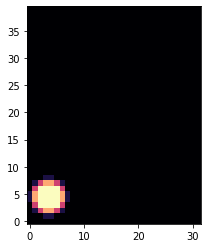

In [5]:
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.1, batch_size=1), physics=IncompressibleFlow())
pylab.imshow(np.concatenate(fluid.density.data[...,0], axis=1), origin='lower', cmap='magma')
world.add(Inflow(Sphere(center=[[5,4]], radius=3), rate=0.2))
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
initial_state = fluid.state  # Remember the state at t=0 for later visualization
session.initialize_variables()
world.step()
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

The simulation is then advanced for 20 time steps, and a plot of the density field for each timestep is displayed to show the frames of the simulation.

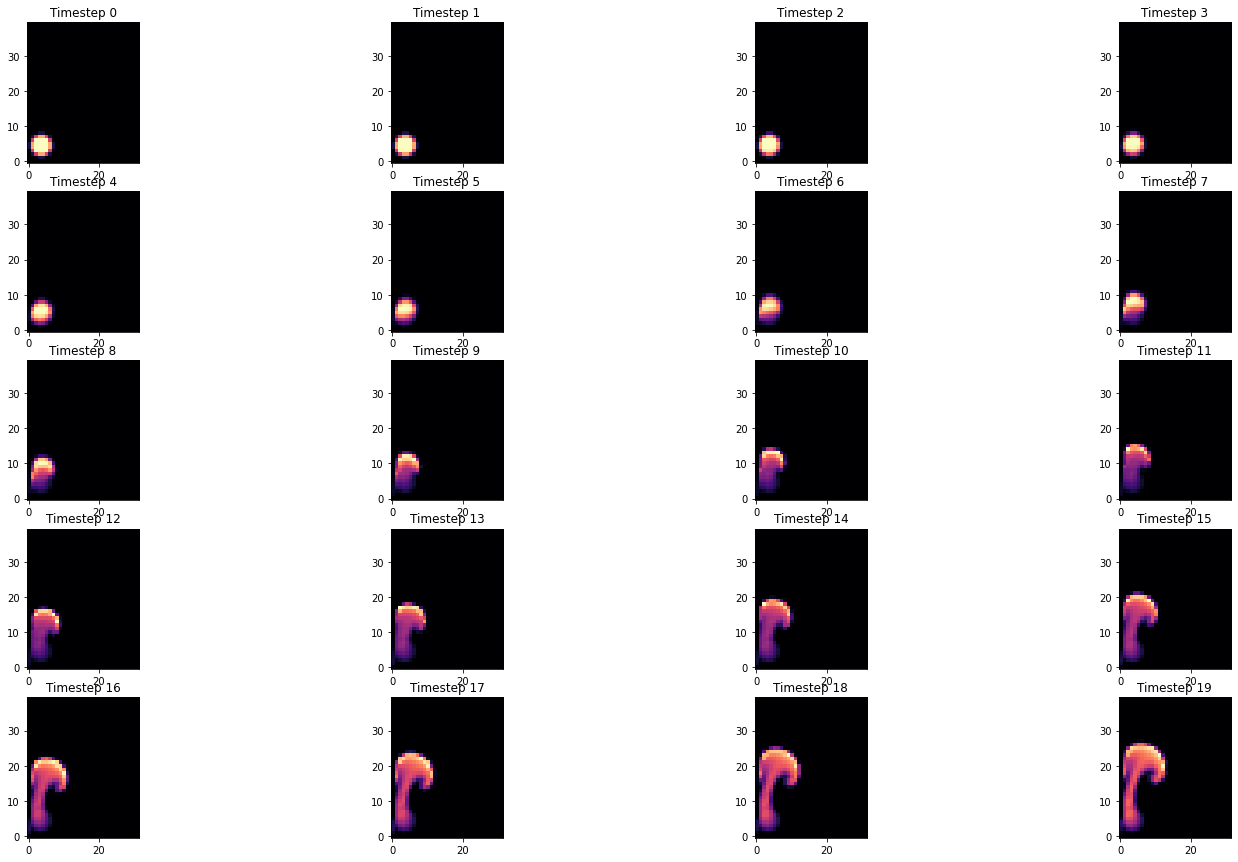

In [6]:
num_frames = 20
rows=int(num_frames/4)
cols=4
fig,axs = pylab.subplots(rows, cols, figsize = (25,15))
for row in range(rows):
  for col in range(cols):
    frame_index = row*(cols)+col
    if(frame_index>19):
      break
    axs[row][col].set_title('Timestep ' + str(frame_index))
    axs[row][col].imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')
    #fluid.velocity+=session_opt.run(force[frame_index])
    world.step()

# **Optimization**

In this example, the adjoint based gradient computation ability of the Φ-Flow physics simulation framework is illustrated. 

The example setup is as follows: 

*   Three simulations with sources placed at different spatial locations in the domain are run in parallel.  
*   The second and third simulation are then controlled so as to have final density fields as close as possible to the final density field of the first simulation.
*   The control is executed through a spatio-temporal force term; implemented as a velocity update.
*   The optimal control force is then computed by optimizing the velocity updates at each timestep for a combined loss; which minimizes the total force applied and the L2-distance between the final states of the simulations. 

The optimization, implemented by the adjoint based backpropagation methods, is integrated with the tensorflow framework - a highlight of their differentiable solver. This simple execution scheme of backpropagating gradients to optimize a variable force term across timesteps is called single shooting optimization.

First, as in the previous example, the simulation is set up. The initial state is displayed in the output.

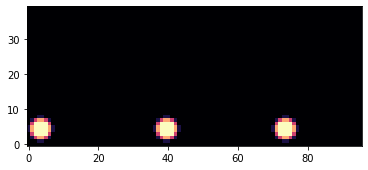

In [7]:
#@title Initial States of the three simulations displayed side by side. (Yellow spheres are the respective sources)
session_opt = Session(None)
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.1, batch_size=3), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[[5,4],[5,8],[5,10]], radius=3), rate=0.2))
#fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
#force=variable(fluid.velocity)
initial_state = fluid.state  # Remember the state at t=0 for later visualization
session_opt.initialize_variables()
world.step()
pylab.imshow(np.concatenate(session_opt.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

The tensorflow graph is then computed by letting the simulation run for 20 frames. On each time step, a distinct 'force' field with dimensions same as the velocity field is initialized as tensorflow variable and added to the velocity field as an update. The 'force' fields are then optimized for our simulation to reach the desired target state while having a minimum cumulative absolute value over time and space.  

These 'force' fields instead of being a simple field initialized to some value and optimized as done here, are parameterized by neural networks in the paper.

In [0]:
#@title Build Tensorflow graph
force = []
num_frames=20
for i in range(num_frames):
  force.append(variable(fluid.velocity))
  session_opt.initialize_variables()
for frame in range(num_frames):
  fluid.velocity+=force[frame]
  #print('Building graph for frame %d' % frame)
  world.step()


The target is set as the final time-step of the first batch of simulations. The loss is then defined as a simple sum of a force loss which is the overall force applied and the L-2 distance between the final states of the second and third simulation and the target state.  

A simple gradient descent optimizer with a learning rate of 0.1 is then used for the optimization. 

In [0]:
target = session_opt.run(fluid.density).data[0,...]
#loss = math.l2_loss(fluid.density.data[1:,...] - target)
#optim = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
#session_opt.initialize_variables()
#print('Initial loss: %f' % session.run(loss))

The initial loss is displayed, followed by a visualization of the initial 'force' fields prior to the optimization for each timestep.

In [10]:
force_loss = math.l2_loss(force)
target_loss = math.l2_loss(fluid.density.data[1:,...] - target)
loss=force_loss+2*target_loss
optim = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session_opt.run(loss))

Initial loss: 64.001434


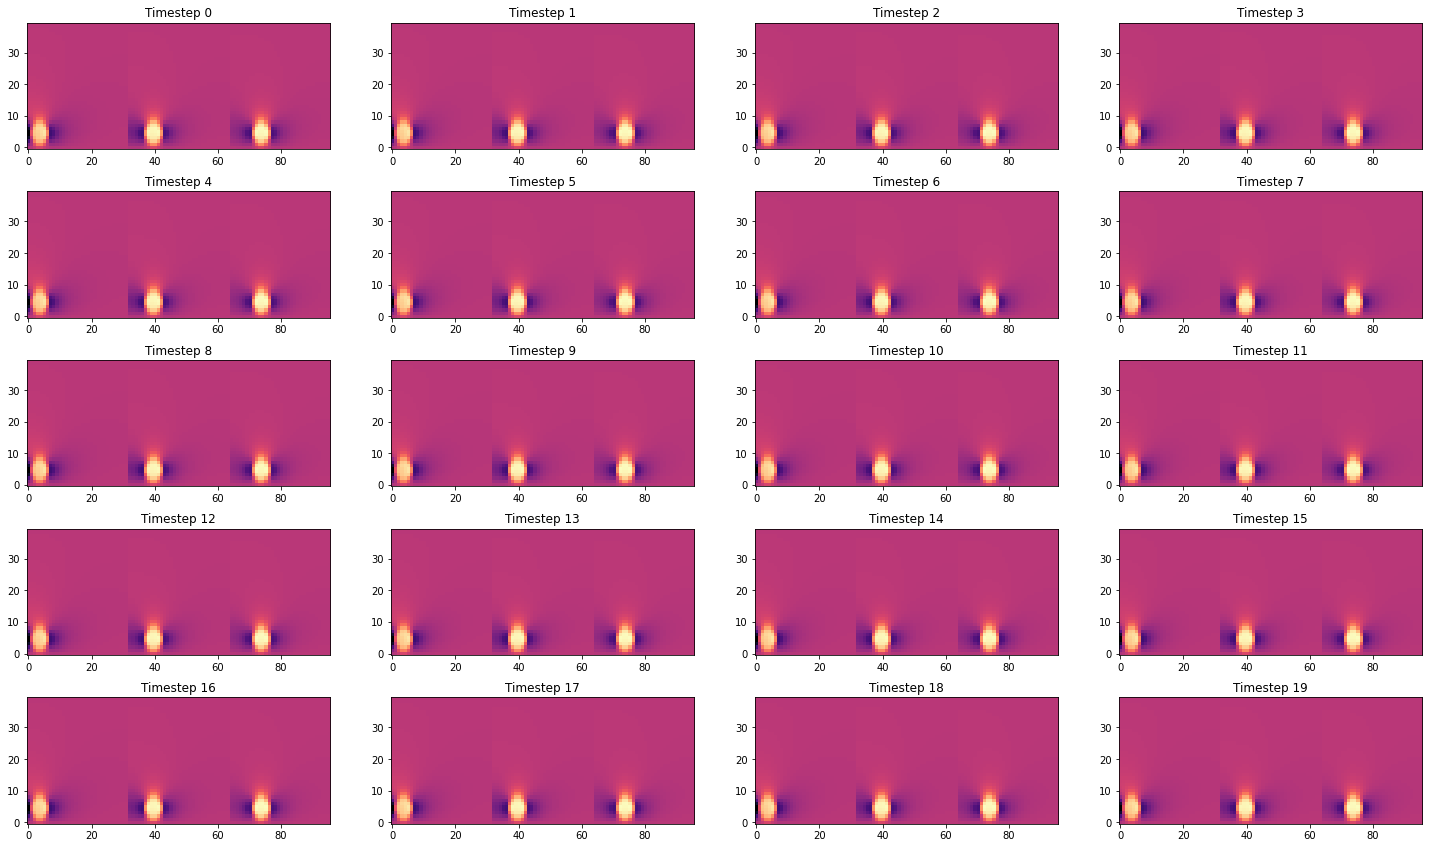

In [11]:
#@title Initial Control Force Fields (Prior to optimization)
rows=int(num_frames/4)
cols=4
force_figs,axs = pylab.subplots(rows, cols, figsize = (25,15))
for row in range(rows):
  for col in range(cols):
    frame_index = row*(cols)+col
    if(frame_index>19):
      break
    axs[row][col].set_title('Timestep ' + str(frame_index))
    axs[row][col].imshow(np.concatenate(session_opt.run(force[frame_index]).at_centers().data[...,0], axis=1), origin='lower', cmap='magma')
#fluid.velocity+=initial_state.density
#pylab.imshow(np.concatenate(session_opt.run(fluid.state.velocity).at_centers().data[...,0], axis=1), origin='lower', cmap='magma')
#print(fluid.state.velocity)

The loss values are displayed as the optimization proceeds.

In [12]:
for optim_step in range(500):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session_opt.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 64.001411
Running optimization step 1. 
Loss: 53.306328
Running optimization step 2. 
Loss: 48.612083
Running optimization step 3. 
Loss: 64.092445
Running optimization step 4. 
Loss: 45.021126
Running optimization step 5. 
Loss: 38.311981
Running optimization step 6. 
Loss: 33.823174
Running optimization step 7. 
Loss: 33.609177
Running optimization step 8. 
Loss: 34.261127
Running optimization step 9. 
Loss: 30.476995
Running optimization step 10. 
Loss: 27.484589
Running optimization step 11. 
Loss: 26.812241
Running optimization step 12. 
Loss: 26.120878
Running optimization step 13. 
Loss: 26.013535
Running optimization step 14. 
Loss: 25.676792
Running optimization step 15. 
Loss: 25.201601
Running optimization step 16. 
Loss: 24.822989
Running optimization step 17. 
Loss: 25.356363
Running optimization step 18. 
Loss: 23.752773
Running optimization step 19. 
Loss: 23.361387
Running optimization step 20.

The optimized control 'force' fields are displayed below.

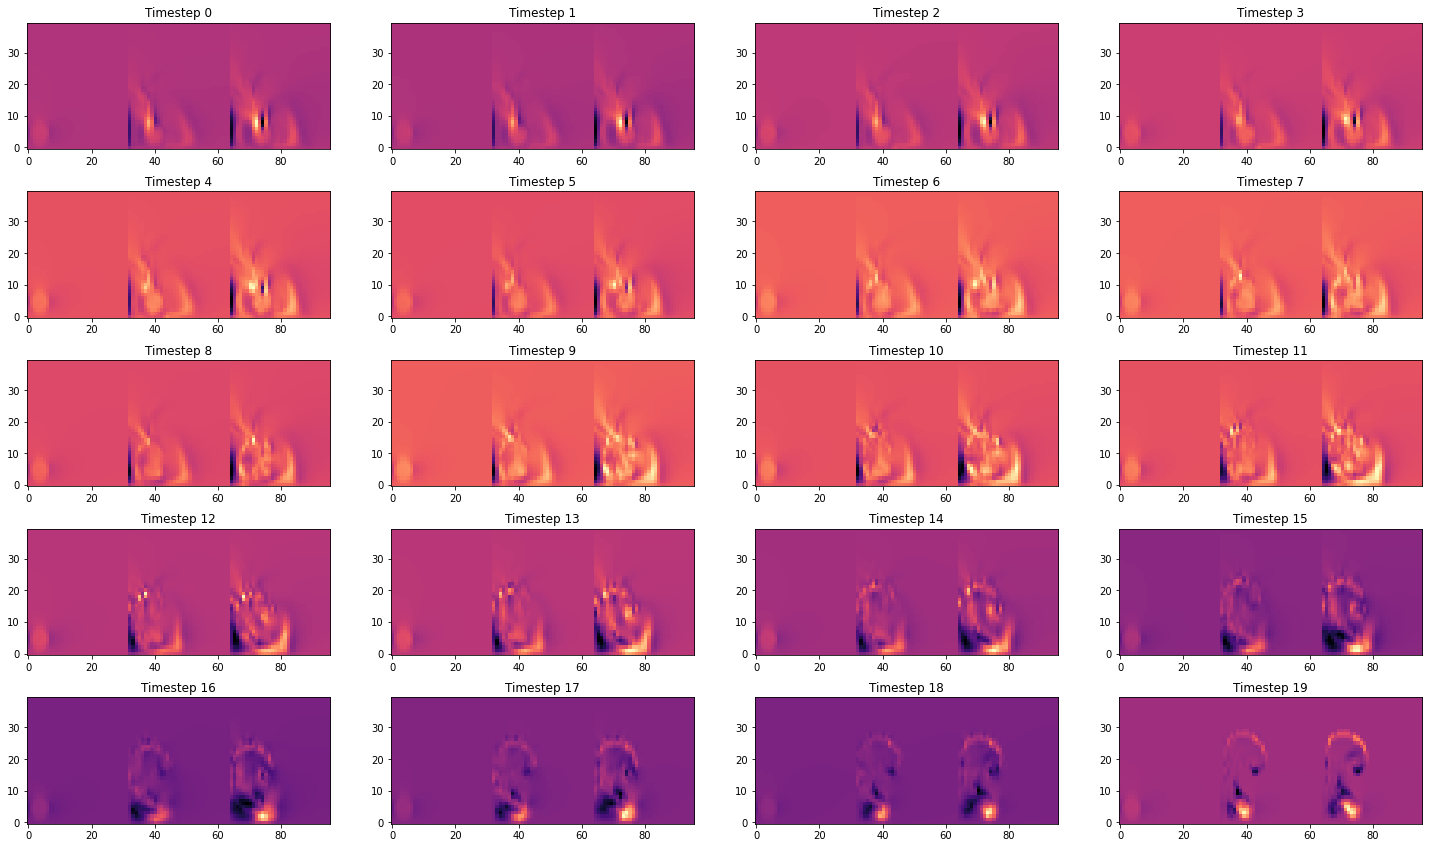

In [13]:
#@title Optimized Control Force Fields
rows=int(num_frames/4)
cols=4
force_figs,axs = pylab.subplots(rows, cols, figsize = (25,15))
for row in range(rows):
  for col in range(cols):
    frame_index = row*(cols)+col
    if(frame_index>19):
      break
    axs[row][col].set_title('Timestep ' + str(frame_index))
    axs[row][col].imshow(np.concatenate(session_opt.run(force[frame_index]).at_centers().data[...,0], axis=1), origin='lower', cmap='magma')


The effect of the force is displayed by first showing the simulation of the natural flow of the density field. The controlled simulation with the effect of the computed control force is displayed thereafter. 

We can see how the 2nd and 3rd simulation are controlled to match the first, even in such a low resolution domain with relatively less number of iterations.

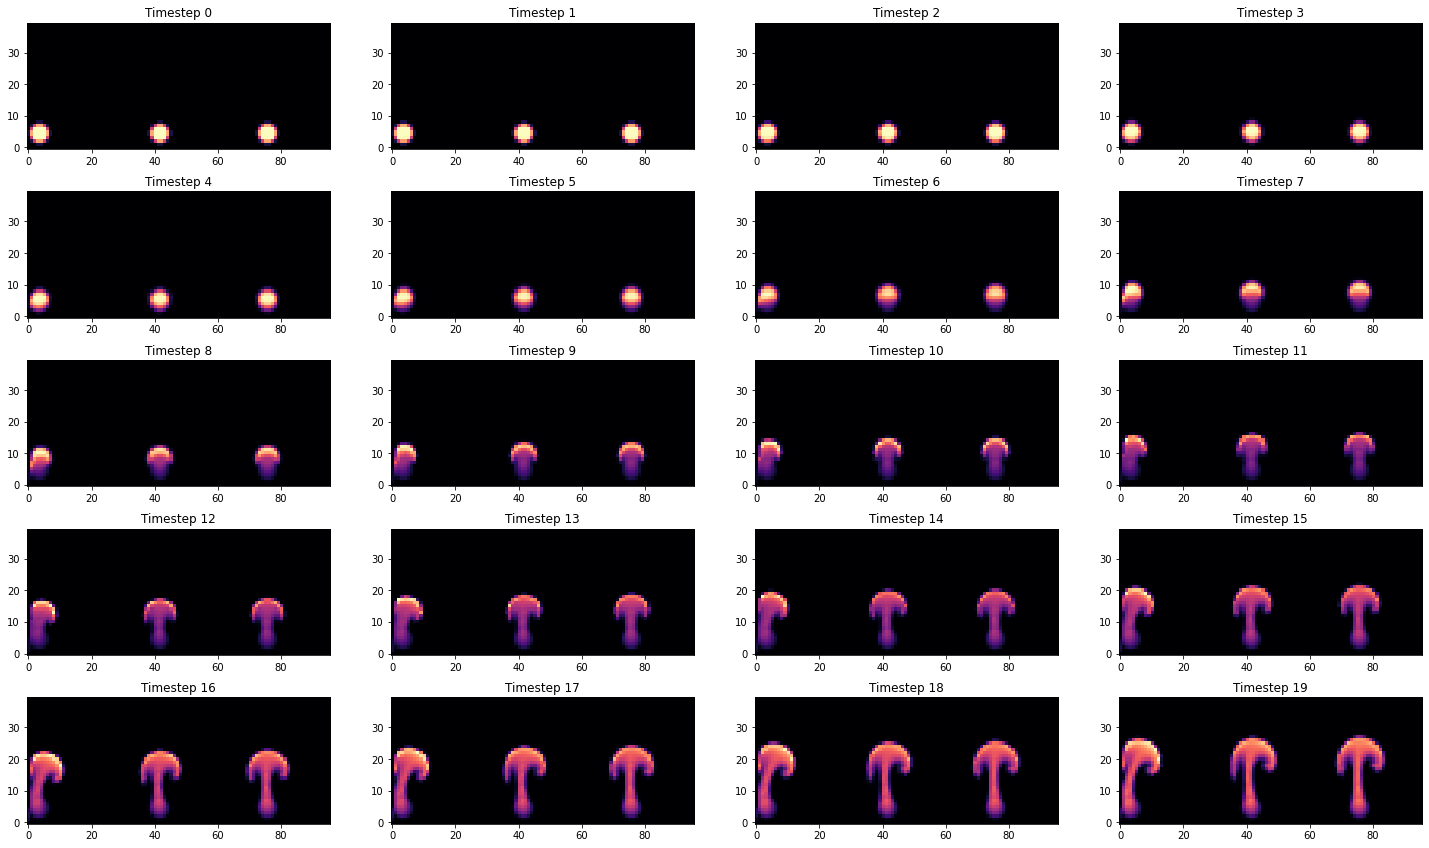

In [14]:
#@title Natural Flow Simulation
session_sim_display=Session(None)
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.1, batch_size=3), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[[5,4],[5,10],[5,12]], radius=3), rate=0.2))
#fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
#force=variable(fluid.velocity)
initial_state = fluid.state  # Remember the state at t=0 for later visualization
world.step()
rows=int(num_frames/4)
cols=4
sim_figs,axs = pylab.subplots(rows, cols, figsize = (25,15))
for row in range(rows):
  for col in range(cols):
    frame_index = row*(cols)+col
    if(frame_index>19):
      break
    axs[row][col].set_title('Timestep ' + str(frame_index))
    axs[row][col].imshow(np.concatenate(session_sim_display.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')
    #fluid.velocity+=session_opt.run(force[frame_index])
    world.step()


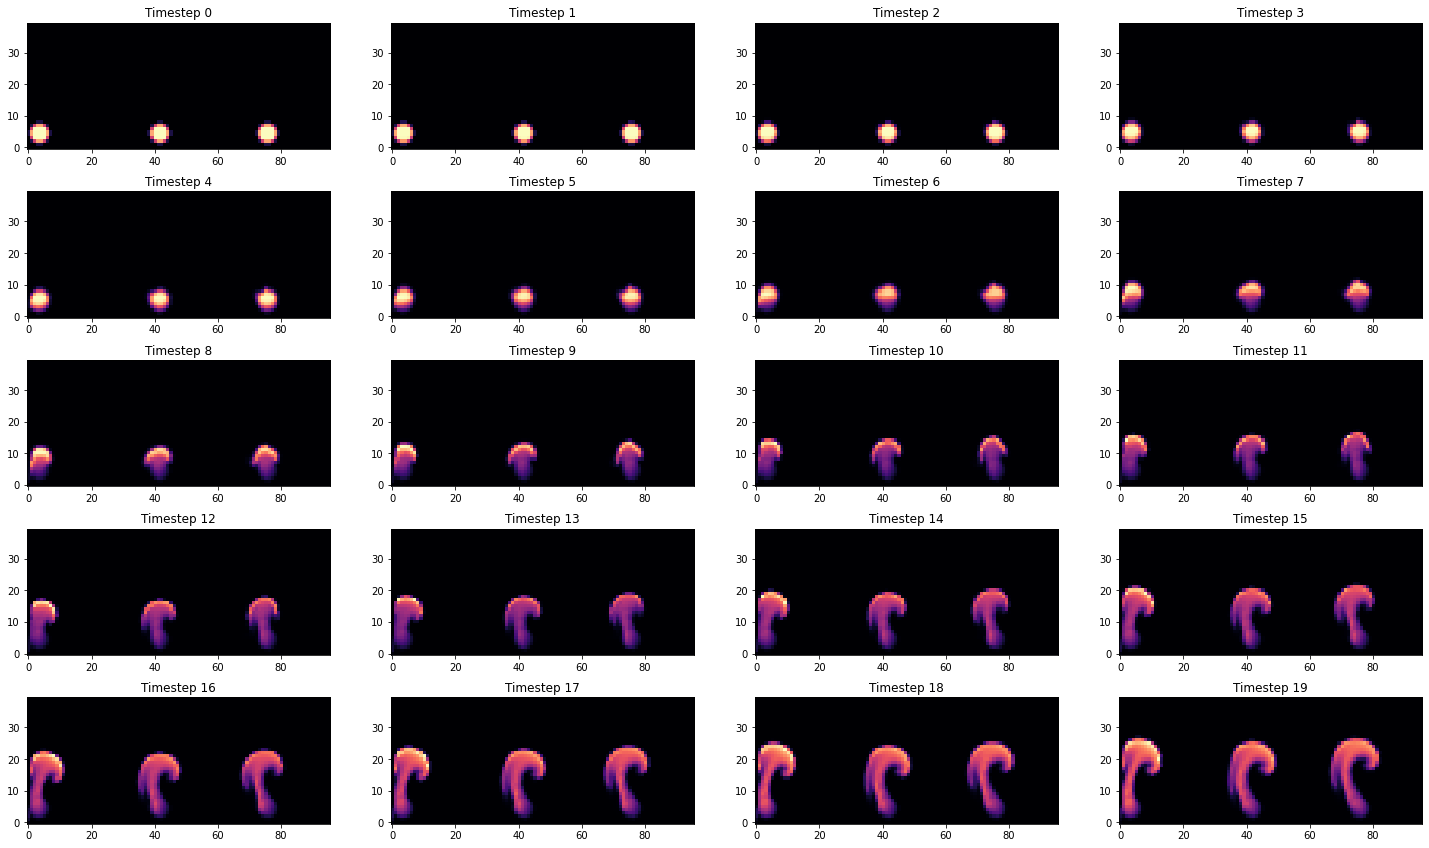

In [15]:
#@title Controlled Simulation
Wsession_sim_display=Session(None)
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.1, batch_size=3), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[[5,4],[5,10],[5,12]], radius=3), rate=0.2))
#fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
#force=variable(fluid.velocity)
initial_state = fluid.state  # Remember the state at t=0 for later visualization
world.step()
rows=int(num_frames/4)
cols=4
sim_figs,axs = pylab.subplots(rows, cols, figsize = (25,15))
for row in range(rows):
  for col in range(cols):
    frame_index = row*(cols)+col
    if(frame_index>19):
      break
    axs[row][col].set_title('Timestep ' + str(frame_index))
    axs[row][col].imshow(np.concatenate(session_sim_display.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')
    fluid.velocity+=session_opt.run(force[frame_index])
    world.step()
